In [4]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from tifffile import TiffFile

Load Data

In [30]:
df_images = pd.read_csv('../data/processed/usgeo-disco-features.csv', index_col='i')
df_images_1992 = df_images[df_images['year'] == 1992].sort('f')
df_images_2013 = df_images[df_images['year'] == 2013].sort('f')
df_images_2013['mean_luminosity_delta'] = (df_images_2013['mean_luminosity'].as_matrix() - df_images_1992['mean_luminosity'].as_matrix()) / df_images_1992['mean_luminosity'].as_matrix() 
df_images = df_images_2013

df_quakes = pd.read_csv('../data/raw/USGSEarthquakeHazards/USGSEarthquakeHazards.csv', index_col=0)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Translate coordinate locations into image x- and y-Axes

In [31]:
def create_coordinate(image):
    image['viirs_x']  = (image['latitude'] + 75) * 16801 / (65+75)
    image['viirs_y']  = (image['longitude'] + 180) * 43201 / 360
    return image

In [32]:
df_quakes['viirs_x'] = df_quakes['viirs_y'] = np.nan
df_quakes = df_quakes.sort('mag',ascending=False)
df_quakes = df_quakes.apply(create_coordinate,axis=1)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  


In [33]:
df_quakes[['viirs_x','viirs_y','latitude','longitude']].head(1)

,viirs_x,viirs_y,latitude,longitude
28763,9395.95925,33118.606617,3.295,95.982


/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  after removing the cwd from sys.path.


Pandas(Index=28763, viirs_x=9395.9592499999999, viirs_y=33118.606616666664)


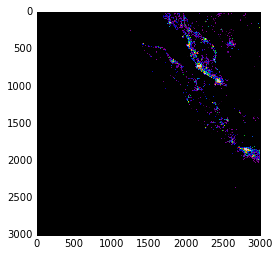

In [34]:
coord = next(df_quakes.sort('mag',ascending=False)[['viirs_x','viirs_y']].itertuples())
print(coord)
d=3000
plt.imshow(images[1,(coord[1]-d/2):(coord[1]+d/2),(coord[2]-d/2):(coord[2]+d/2)],cmap='spectral')
plt.show()

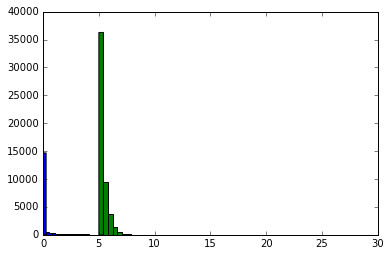

In [35]:
plt.hist(df_images['mean_luminosity'],bins=100)
plt.hist(df_quakes['mag'],bins=10)
plt.show()

In [37]:
df_images = df_images[df_images['mean_luminosity'] > 10]
df_quakes = df_quakes[df_quakes['mag'] > 5]
print('These configurations make %i iterations.' % (df_images.shape[0] * df_quakes.shape[0]))

These configurations make 7619862 iterations.


In [38]:
df_images['center_x'] = df_images['pxlb'] - (df_images['pxlb'] - df_images['pxlt']) / 2
df_images['center_y'] = df_images['pxll'] - (df_images['pxll'] - df_images['pxlr']) / 2

In [39]:
def calculate_disaster_coefficient(image):
    disco = 0
    for q in df_quakes[['viirs_x','viirs_y']].itertuples():
        disco = disco + abs(25 - np.sqrt(np.linalg.norm([
            image['center_x'] - q[1],
            image['center_y'] - q[2]
        ])))
        
    image['disco'] = disco / df_quakes.shape[0]
    return image

In [40]:
%%time
df_images['disco'] = np.nan
df_images = df_images.apply(calculate_disaster_coefficient,axis=1)
df_images.head()

CPU times: user 4min 24s, sys: 3.76 s, total: 4min 28s
Wall time: 4min 34s


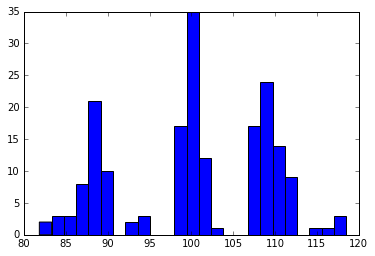

In [41]:
plt.hist(df_images['disco'],bins=25)
plt.show()

In [44]:
from sklearn.preprocessing import normalize
df_images['disconorm'] = normalize(df_images['disco'])[0]

/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


/usr/local/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [86]:
gp_mean.shape

(50,)

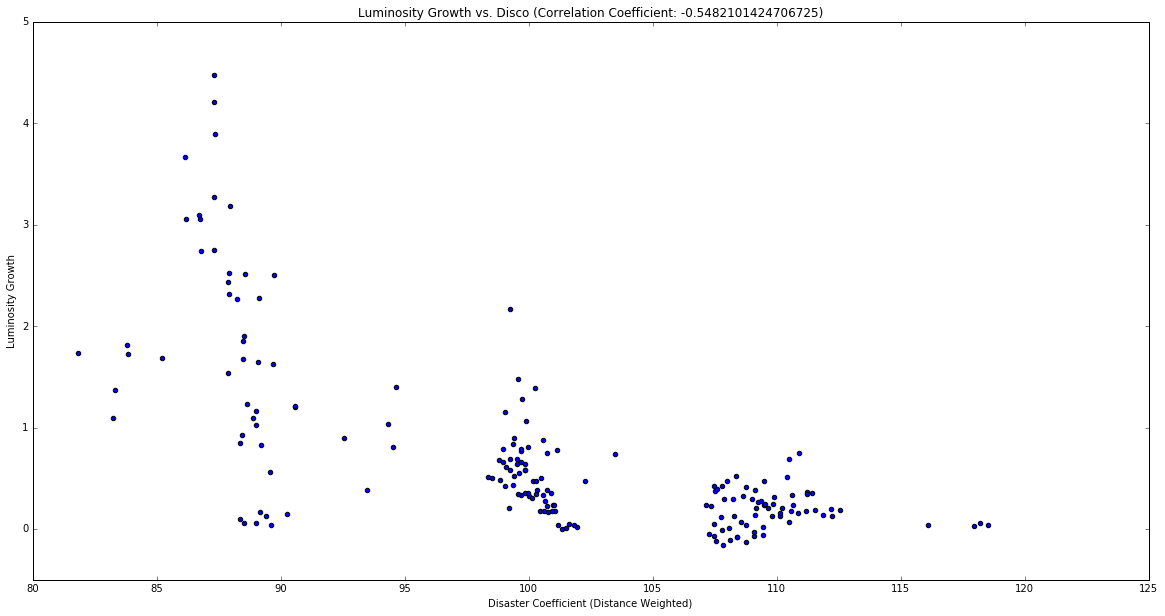

In [89]:
plt.figure(figsize=(20,10))
plt.scatter(df_images['disco'],df_images['mean_luminosity_delta'])
plt.xlabel('Disaster Coefficient (Distance Weighted)')
plt.ylabel('Luminosity Growth')
plt.title('Luminosity Growth vs. Disco (Correlation Coefficient: {:.2f})'
          .format(np.corrcoef(df_images['mean_luminosity_delta'], df_images['disconorm'])[0,1]))
plt.ylim([-0.5,5])
plt.savefig('../reports/figures/linear-lum-vs-disco.png')
plt.show()